In [1]:
# Google API dashboard:
# https://console.cloud.google.com/apis/dashboard?project=my-project-1543901530556&consoleReturnUrl=https:%2F%2Fcloud.google.com%2Fmaps-platform%2F%3Fapis%3Dmaps%26project%3Dmy-project-1543901530556&consoleUI=CLOUD&duration=PT1H
# Google elevation request guide:
# https://developers.google.com/maps/documentation/elevation/intro#ElevationRequests

In [2]:
# Import all packages and helpter functions
import sys
sys.path.append('../')
from utils import *

In [3]:
edge = pd.read_csv(raw_path + '5c_edges2.csv')
print(edge.shape)
edge.head(3)

(2464, 15)


,access,area,geometry,highway,key,landuse,lanes,length,name,oneway,osmid,ref,service,u,v
0,private,NaN,"LINESTRING (-117.7092997 34.1029743, -117.7093...",service,0,NaN,NaN,20.998,Amherst Avenue,False,13433612,NaN,NaN,3835445345,5366824647
1,private,NaN,"LINESTRING (-117.7092997 34.1029743, -117.7093...",service,0,NaN,NaN,241.977,"['East 9th Street', 'Amherst Avenue']",False,"[13433612, 13441725]",NaN,NaN,3835445345,123586950
2,NaN,NaN,"LINESTRING (-117.7092997 34.1029743, -117.7092...",path,0,NaN,NaN,109.109,Quotation Walk,False,380203392,NaN,NaN,3835445345,3835445353


We observe that edges are not simple line segments. It could have several nodes in there, and has different shapes, e.g. arcs or lines.

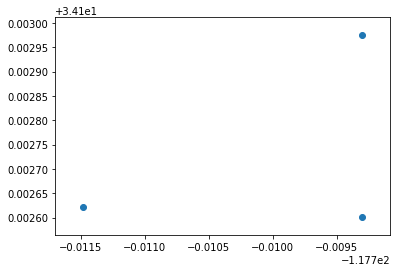

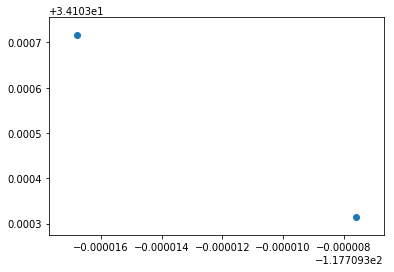

In [4]:
visualize_path(edge, 1)
visualize_path(edge, 100)

In [5]:
process_edge_csv_rows(edge, 1)

([-117.7092997, -117.7093017],
 [-117.7093017, -117.7114799],
 [34.1029743, 34.1026019],
 [34.1026019, 34.1026228],
 ['service', 'service'],
 [False, False],
 [1, 1])

In [6]:
clean_edge = defaultdict(list)
for idx in edge.index:
    y_start, y_end, x_start, x_end, highway, oneway, edge_index = process_edge_csv_rows(edge, idx)
    clean_edge['y_start'] += y_start
    clean_edge['y_end'] += y_end
    clean_edge['x_start'] += x_start
    clean_edge['x_end'] += x_end
    clean_edge['highway'] += highway
    clean_edge['oneway'] += oneway
    clean_edge['edge_index'] += edge_index
clean_edge = pd.DataFrame(clean_edge)
clean_edge.head()

,y_start,y_end,x_start,x_end,highway,oneway,edge_index
0,-117.709300,-117.709304,34.102974,34.103163,service,False,0
1,-117.709300,-117.709302,34.102974,34.102602,service,False,1
2,-117.709302,-117.711480,34.102602,34.102623,service,False,1
3,-117.709300,-117.709206,34.102974,34.102967,path,False,2
4,-117.709206,-117.709089,34.102967,34.102963,path,False,2


count    6484.000000
mean       19.961113
std        35.857989
min         0.166500
25%         4.397441
50%         8.642140
75%        20.171479
max       958.679002
Name: length, dtype: float64


/Users/zihaoxu/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


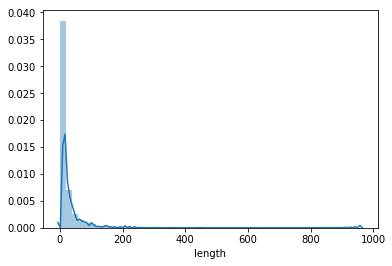

In [7]:
path_lengths = [get_path_length(clean_edge, i) for i in range(len(clean_edge))]
clean_edge['length'] = path_lengths
print(clean_edge['length'].describe())
sns.distplot(clean_edge['length'])

In [8]:
seg_length = 5
print("Total number of edges less than", str(seg_length), "m:", sum([l<seg_length for l in clean_edge['length']]))
print("Total number of nodes in the new graph (overestimate):", sum([l//seg_length+1 for l in clean_edge['length']]))

Total number of edges less than 5 m: 1999
Total number of nodes in the new graph (overestimate): 29045.0


In [9]:
break_up_edges_to_nodes(clean_edge, 14, seg_length)

,y_start,y_end,x_start,x_end,highway,oneway,edge_index,length
0,-117.708159,-117.708128,34.105097,34.105131,footway,False,4,5.085896
1,-117.708128,-117.708096,34.105131,34.105164,footway,False,4,5.085896
2,-117.708096,-117.708065,34.105164,34.105197,footway,False,4,5.085896
3,-117.708065,-117.708034,34.105197,34.105231,footway,False,4,5.085896
4,-117.708034,-117.708003,34.105231,34.105264,footway,False,4,5.085896
5,-117.708003,-117.707971,34.105264,34.105298,footway,False,4,5.085896
6,-117.707971,-117.707940,34.105298,34.105331,footway,False,4,5.085896


In [10]:
for idx in clean_edge.index:
    if idx == 0:
        output = break_up_edges_to_nodes(clean_edge, idx, seg_length)
    else:
        output = pd.concat([output, break_up_edges_to_nodes(clean_edge, idx, seg_length)])
print(output.shape)
output.head()

(24560, 8)


,y_start,y_end,x_start,x_end,highway,oneway,edge_index,length
0,-117.709300,-117.709301,34.102974,34.103021,service,False,0,5.254779
1,-117.709301,-117.709302,34.103021,34.103069,service,False,0,5.254779
2,-117.709302,-117.709303,34.103069,34.103116,service,False,0,5.254779
3,-117.709303,-117.709304,34.103116,34.103163,service,False,0,5.254779
0,-117.709300,-117.709300,34.102974,34.102928,service,False,1,5.181089


Observe that after the transformation, the path length are all under 10, mostly concentrated around 5 meters.

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


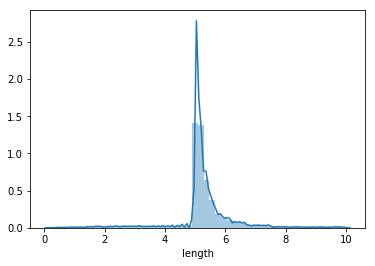

In [11]:
sns.distplot(output['length'])

In [12]:
output.to_csv(mst_path + 'clean_edge2.csv', index = None)